# Convolutional Neural Network  - Transfer Learning

Dataset in use: https://www.kaggle.com/datasets/cashutosh/gender-classification-dataset/data

In [1]:
import torch
import torchvision
import torch.nn as nn
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
train_dir = "./dataset/Training"
val_dir = "./dataset/Validation"
input_size = (224, 224)
batch_size = 64

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
transform = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
image_datasets = {
    'train': datasets.ImageFolder(root=train_dir, transform=transform['train']),
    'val': datasets.ImageFolder(root=val_dir, transform=transform['val'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False)
}

In [6]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [7]:
# Load Model
model = models.vgg16(pretrained=True)

# Freeze Layers
for param in model.parameters():
    param.requires_grad = False

# Custom Classifier
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.1), # Dropout is applied with probability 0.1 to prevent overfitting
    nn.Linear(256, 2)  # Output is 2 dimensional (male and female)
)

model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.013) # Adam Optimizer

scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

C:\Users\aerol\env\facenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\aerol\env\facenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training

In [8]:
all_preds = []
all_labels = []

In [9]:
num_epochs = 3
for epoch in range(num_epochs):
    
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0
        total_batches = len(dataloaders[phase])

        for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            batch_loss = loss.item()
            print(f'Epoch [{epoch+1}/{num_epochs}], Phase: {phase}, Batch: [{batch_idx+1}/{total_batches}], Loss: {batch_loss:.4f}')

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        scheduler.step()

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

Epoch [1/3], Phase: train, Batch: [1/730], Loss: 0.7068
Epoch [1/3], Phase: train, Batch: [2/730], Loss: 4.2294
Epoch [1/3], Phase: train, Batch: [3/730], Loss: 9.2497
Epoch [1/3], Phase: train, Batch: [4/730], Loss: 4.7356
Epoch [1/3], Phase: train, Batch: [5/730], Loss: 0.6188
Epoch [1/3], Phase: train, Batch: [6/730], Loss: 2.7425
Epoch [1/3], Phase: train, Batch: [7/730], Loss: 2.9531
Epoch [1/3], Phase: train, Batch: [8/730], Loss: 1.0421
Epoch [1/3], Phase: train, Batch: [9/730], Loss: 0.5554
Epoch [1/3], Phase: train, Batch: [10/730], Loss: 0.5963
Epoch [1/3], Phase: train, Batch: [11/730], Loss: 0.4012
Epoch [1/3], Phase: train, Batch: [12/730], Loss: 0.6129
Epoch [1/3], Phase: train, Batch: [13/730], Loss: 0.4655
Epoch [1/3], Phase: train, Batch: [14/730], Loss: 0.4602
Epoch [1/3], Phase: train, Batch: [15/730], Loss: 0.3687
Epoch [1/3], Phase: train, Batch: [16/730], Loss: 0.3149
Epoch [1/3], Phase: train, Batch: [17/730], Loss: 0.2650
Epoch [1/3], Phase: train, Batch: [18/73

Epoch [1/3], Phase: train, Batch: [145/730], Loss: 0.3426
Epoch [1/3], Phase: train, Batch: [146/730], Loss: 0.3488
Epoch [1/3], Phase: train, Batch: [147/730], Loss: 0.4372
Epoch [1/3], Phase: train, Batch: [148/730], Loss: 0.2193
Epoch [1/3], Phase: train, Batch: [149/730], Loss: 0.3515
Epoch [1/3], Phase: train, Batch: [150/730], Loss: 0.2693
Epoch [1/3], Phase: train, Batch: [151/730], Loss: 0.3653
Epoch [1/3], Phase: train, Batch: [152/730], Loss: 0.1947
Epoch [1/3], Phase: train, Batch: [153/730], Loss: 0.2810
Epoch [1/3], Phase: train, Batch: [154/730], Loss: 0.2406
Epoch [1/3], Phase: train, Batch: [155/730], Loss: 0.2733
Epoch [1/3], Phase: train, Batch: [156/730], Loss: 0.2209
Epoch [1/3], Phase: train, Batch: [157/730], Loss: 0.3785
Epoch [1/3], Phase: train, Batch: [158/730], Loss: 0.3904
Epoch [1/3], Phase: train, Batch: [159/730], Loss: 0.4399
Epoch [1/3], Phase: train, Batch: [160/730], Loss: 0.4562
Epoch [1/3], Phase: train, Batch: [161/730], Loss: 0.3352
Epoch [1/3], P

Epoch [1/3], Phase: train, Batch: [287/730], Loss: 0.2360
Epoch [1/3], Phase: train, Batch: [288/730], Loss: 0.3738
Epoch [1/3], Phase: train, Batch: [289/730], Loss: 0.3671
Epoch [1/3], Phase: train, Batch: [290/730], Loss: 0.1933
Epoch [1/3], Phase: train, Batch: [291/730], Loss: 0.2732
Epoch [1/3], Phase: train, Batch: [292/730], Loss: 0.2816
Epoch [1/3], Phase: train, Batch: [293/730], Loss: 0.3587
Epoch [1/3], Phase: train, Batch: [294/730], Loss: 0.2055
Epoch [1/3], Phase: train, Batch: [295/730], Loss: 0.3202
Epoch [1/3], Phase: train, Batch: [296/730], Loss: 0.3437
Epoch [1/3], Phase: train, Batch: [297/730], Loss: 0.3512
Epoch [1/3], Phase: train, Batch: [298/730], Loss: 0.3548
Epoch [1/3], Phase: train, Batch: [299/730], Loss: 0.4298
Epoch [1/3], Phase: train, Batch: [300/730], Loss: 0.2174
Epoch [1/3], Phase: train, Batch: [301/730], Loss: 0.1949
Epoch [1/3], Phase: train, Batch: [302/730], Loss: 0.3315
Epoch [1/3], Phase: train, Batch: [303/730], Loss: 0.5304
Epoch [1/3], P

Epoch [1/3], Phase: train, Batch: [429/730], Loss: 0.1974
Epoch [1/3], Phase: train, Batch: [430/730], Loss: 0.4713
Epoch [1/3], Phase: train, Batch: [431/730], Loss: 0.3826
Epoch [1/3], Phase: train, Batch: [432/730], Loss: 0.2681
Epoch [1/3], Phase: train, Batch: [433/730], Loss: 0.2210
Epoch [1/3], Phase: train, Batch: [434/730], Loss: 0.3239
Epoch [1/3], Phase: train, Batch: [435/730], Loss: 0.2145
Epoch [1/3], Phase: train, Batch: [436/730], Loss: 0.3090
Epoch [1/3], Phase: train, Batch: [437/730], Loss: 0.2202
Epoch [1/3], Phase: train, Batch: [438/730], Loss: 0.2026
Epoch [1/3], Phase: train, Batch: [439/730], Loss: 0.1631
Epoch [1/3], Phase: train, Batch: [440/730], Loss: 0.3645
Epoch [1/3], Phase: train, Batch: [441/730], Loss: 0.2053
Epoch [1/3], Phase: train, Batch: [442/730], Loss: 0.2177
Epoch [1/3], Phase: train, Batch: [443/730], Loss: 0.2327
Epoch [1/3], Phase: train, Batch: [444/730], Loss: 0.2082
Epoch [1/3], Phase: train, Batch: [445/730], Loss: 0.3420
Epoch [1/3], P

Epoch [1/3], Phase: train, Batch: [571/730], Loss: 0.2906
Epoch [1/3], Phase: train, Batch: [572/730], Loss: 0.1608
Epoch [1/3], Phase: train, Batch: [573/730], Loss: 0.2599
Epoch [1/3], Phase: train, Batch: [574/730], Loss: 0.2150
Epoch [1/3], Phase: train, Batch: [575/730], Loss: 0.4375
Epoch [1/3], Phase: train, Batch: [576/730], Loss: 0.4886
Epoch [1/3], Phase: train, Batch: [577/730], Loss: 0.4639
Epoch [1/3], Phase: train, Batch: [578/730], Loss: 0.3467
Epoch [1/3], Phase: train, Batch: [579/730], Loss: 0.4104
Epoch [1/3], Phase: train, Batch: [580/730], Loss: 0.2552
Epoch [1/3], Phase: train, Batch: [581/730], Loss: 0.3008
Epoch [1/3], Phase: train, Batch: [582/730], Loss: 0.3541
Epoch [1/3], Phase: train, Batch: [583/730], Loss: 0.3694
Epoch [1/3], Phase: train, Batch: [584/730], Loss: 0.2977
Epoch [1/3], Phase: train, Batch: [585/730], Loss: 0.3184
Epoch [1/3], Phase: train, Batch: [586/730], Loss: 0.3424
Epoch [1/3], Phase: train, Batch: [587/730], Loss: 0.3507
Epoch [1/3], P

Epoch [1/3], Phase: train, Batch: [713/730], Loss: 0.1774
Epoch [1/3], Phase: train, Batch: [714/730], Loss: 0.4648
Epoch [1/3], Phase: train, Batch: [715/730], Loss: 0.3764
Epoch [1/3], Phase: train, Batch: [716/730], Loss: 0.2634
Epoch [1/3], Phase: train, Batch: [717/730], Loss: 0.2960
Epoch [1/3], Phase: train, Batch: [718/730], Loss: 0.4019
Epoch [1/3], Phase: train, Batch: [719/730], Loss: 0.2354
Epoch [1/3], Phase: train, Batch: [720/730], Loss: 0.3826
Epoch [1/3], Phase: train, Batch: [721/730], Loss: 0.4400
Epoch [1/3], Phase: train, Batch: [722/730], Loss: 0.2484
Epoch [1/3], Phase: train, Batch: [723/730], Loss: 0.3020
Epoch [1/3], Phase: train, Batch: [724/730], Loss: 0.2062
Epoch [1/3], Phase: train, Batch: [725/730], Loss: 0.2585
Epoch [1/3], Phase: train, Batch: [726/730], Loss: 0.5050
Epoch [1/3], Phase: train, Batch: [727/730], Loss: 0.3148
Epoch [1/3], Phase: train, Batch: [728/730], Loss: 0.4179
Epoch [1/3], Phase: train, Batch: [729/730], Loss: 0.3665
Epoch [1/3], P

Epoch [1/3], Phase: val, Batch: [131/182], Loss: 0.1927
Epoch [1/3], Phase: val, Batch: [132/182], Loss: 0.1951
Epoch [1/3], Phase: val, Batch: [133/182], Loss: 0.2801
Epoch [1/3], Phase: val, Batch: [134/182], Loss: 0.1252
Epoch [1/3], Phase: val, Batch: [135/182], Loss: 0.1840
Epoch [1/3], Phase: val, Batch: [136/182], Loss: 0.2445
Epoch [1/3], Phase: val, Batch: [137/182], Loss: 0.1959
Epoch [1/3], Phase: val, Batch: [138/182], Loss: 0.2280
Epoch [1/3], Phase: val, Batch: [139/182], Loss: 0.1435
Epoch [1/3], Phase: val, Batch: [140/182], Loss: 0.2117
Epoch [1/3], Phase: val, Batch: [141/182], Loss: 0.1677
Epoch [1/3], Phase: val, Batch: [142/182], Loss: 0.1615
Epoch [1/3], Phase: val, Batch: [143/182], Loss: 0.2511
Epoch [1/3], Phase: val, Batch: [144/182], Loss: 0.2581
Epoch [1/3], Phase: val, Batch: [145/182], Loss: 0.1372
Epoch [1/3], Phase: val, Batch: [146/182], Loss: 0.1386
Epoch [1/3], Phase: val, Batch: [147/182], Loss: 0.1855
Epoch [1/3], Phase: val, Batch: [148/182], Loss:

Epoch [2/3], Phase: train, Batch: [94/730], Loss: 0.2479
Epoch [2/3], Phase: train, Batch: [95/730], Loss: 0.1868
Epoch [2/3], Phase: train, Batch: [96/730], Loss: 0.2580
Epoch [2/3], Phase: train, Batch: [97/730], Loss: 0.3349
Epoch [2/3], Phase: train, Batch: [98/730], Loss: 0.2994
Epoch [2/3], Phase: train, Batch: [99/730], Loss: 0.2728
Epoch [2/3], Phase: train, Batch: [100/730], Loss: 0.3810
Epoch [2/3], Phase: train, Batch: [101/730], Loss: 0.3188
Epoch [2/3], Phase: train, Batch: [102/730], Loss: 0.3077
Epoch [2/3], Phase: train, Batch: [103/730], Loss: 0.2629
Epoch [2/3], Phase: train, Batch: [104/730], Loss: 0.3601
Epoch [2/3], Phase: train, Batch: [105/730], Loss: 0.2357
Epoch [2/3], Phase: train, Batch: [106/730], Loss: 0.3079
Epoch [2/3], Phase: train, Batch: [107/730], Loss: 0.2314
Epoch [2/3], Phase: train, Batch: [108/730], Loss: 0.2348
Epoch [2/3], Phase: train, Batch: [109/730], Loss: 0.4168
Epoch [2/3], Phase: train, Batch: [110/730], Loss: 0.3672
Epoch [2/3], Phase: 

Epoch [2/3], Phase: train, Batch: [236/730], Loss: 0.3120
Epoch [2/3], Phase: train, Batch: [237/730], Loss: 0.2539
Epoch [2/3], Phase: train, Batch: [238/730], Loss: 0.4449
Epoch [2/3], Phase: train, Batch: [239/730], Loss: 0.4107
Epoch [2/3], Phase: train, Batch: [240/730], Loss: 0.2708
Epoch [2/3], Phase: train, Batch: [241/730], Loss: 0.2541
Epoch [2/3], Phase: train, Batch: [242/730], Loss: 0.1680
Epoch [2/3], Phase: train, Batch: [243/730], Loss: 0.4344
Epoch [2/3], Phase: train, Batch: [244/730], Loss: 0.1323
Epoch [2/3], Phase: train, Batch: [245/730], Loss: 0.2243
Epoch [2/3], Phase: train, Batch: [246/730], Loss: 0.2643
Epoch [2/3], Phase: train, Batch: [247/730], Loss: 0.2407
Epoch [2/3], Phase: train, Batch: [248/730], Loss: 0.3051
Epoch [2/3], Phase: train, Batch: [249/730], Loss: 0.3413
Epoch [2/3], Phase: train, Batch: [250/730], Loss: 0.2410
Epoch [2/3], Phase: train, Batch: [251/730], Loss: 0.2461
Epoch [2/3], Phase: train, Batch: [252/730], Loss: 0.2661
Epoch [2/3], P

Epoch [2/3], Phase: train, Batch: [378/730], Loss: 0.1667
Epoch [2/3], Phase: train, Batch: [379/730], Loss: 0.3167
Epoch [2/3], Phase: train, Batch: [380/730], Loss: 0.2700
Epoch [2/3], Phase: train, Batch: [381/730], Loss: 0.4245
Epoch [2/3], Phase: train, Batch: [382/730], Loss: 0.3765
Epoch [2/3], Phase: train, Batch: [383/730], Loss: 0.2832
Epoch [2/3], Phase: train, Batch: [384/730], Loss: 0.2426
Epoch [2/3], Phase: train, Batch: [385/730], Loss: 0.3374
Epoch [2/3], Phase: train, Batch: [386/730], Loss: 0.3866
Epoch [2/3], Phase: train, Batch: [387/730], Loss: 0.1987
Epoch [2/3], Phase: train, Batch: [388/730], Loss: 0.3323
Epoch [2/3], Phase: train, Batch: [389/730], Loss: 0.2287
Epoch [2/3], Phase: train, Batch: [390/730], Loss: 0.2591
Epoch [2/3], Phase: train, Batch: [391/730], Loss: 0.3801
Epoch [2/3], Phase: train, Batch: [392/730], Loss: 0.5815
Epoch [2/3], Phase: train, Batch: [393/730], Loss: 0.4100
Epoch [2/3], Phase: train, Batch: [394/730], Loss: 0.1837
Epoch [2/3], P

Epoch [2/3], Phase: train, Batch: [520/730], Loss: 0.1630
Epoch [2/3], Phase: train, Batch: [521/730], Loss: 0.3545
Epoch [2/3], Phase: train, Batch: [522/730], Loss: 0.4566
Epoch [2/3], Phase: train, Batch: [523/730], Loss: 0.5642
Epoch [2/3], Phase: train, Batch: [524/730], Loss: 0.2222
Epoch [2/3], Phase: train, Batch: [525/730], Loss: 0.2605
Epoch [2/3], Phase: train, Batch: [526/730], Loss: 0.3538
Epoch [2/3], Phase: train, Batch: [527/730], Loss: 0.2488
Epoch [2/3], Phase: train, Batch: [528/730], Loss: 0.3927
Epoch [2/3], Phase: train, Batch: [529/730], Loss: 0.3792
Epoch [2/3], Phase: train, Batch: [530/730], Loss: 0.2402
Epoch [2/3], Phase: train, Batch: [531/730], Loss: 0.3005
Epoch [2/3], Phase: train, Batch: [532/730], Loss: 0.2448
Epoch [2/3], Phase: train, Batch: [533/730], Loss: 0.2528
Epoch [2/3], Phase: train, Batch: [534/730], Loss: 0.3182
Epoch [2/3], Phase: train, Batch: [535/730], Loss: 0.4784
Epoch [2/3], Phase: train, Batch: [536/730], Loss: 0.3550
Epoch [2/3], P

Epoch [2/3], Phase: train, Batch: [662/730], Loss: 0.3194
Epoch [2/3], Phase: train, Batch: [663/730], Loss: 0.2445
Epoch [2/3], Phase: train, Batch: [664/730], Loss: 0.1634
Epoch [2/3], Phase: train, Batch: [665/730], Loss: 0.2557
Epoch [2/3], Phase: train, Batch: [666/730], Loss: 0.2748
Epoch [2/3], Phase: train, Batch: [667/730], Loss: 0.2595
Epoch [2/3], Phase: train, Batch: [668/730], Loss: 0.1661
Epoch [2/3], Phase: train, Batch: [669/730], Loss: 0.3655
Epoch [2/3], Phase: train, Batch: [670/730], Loss: 0.3463
Epoch [2/3], Phase: train, Batch: [671/730], Loss: 0.2068
Epoch [2/3], Phase: train, Batch: [672/730], Loss: 0.2993
Epoch [2/3], Phase: train, Batch: [673/730], Loss: 0.2273
Epoch [2/3], Phase: train, Batch: [674/730], Loss: 0.3015
Epoch [2/3], Phase: train, Batch: [675/730], Loss: 0.2938
Epoch [2/3], Phase: train, Batch: [676/730], Loss: 0.2029
Epoch [2/3], Phase: train, Batch: [677/730], Loss: 0.2699
Epoch [2/3], Phase: train, Batch: [678/730], Loss: 0.4284
Epoch [2/3], P

Epoch [2/3], Phase: val, Batch: [77/182], Loss: 0.1265
Epoch [2/3], Phase: val, Batch: [78/182], Loss: 0.1233
Epoch [2/3], Phase: val, Batch: [79/182], Loss: 0.1925
Epoch [2/3], Phase: val, Batch: [80/182], Loss: 0.1526
Epoch [2/3], Phase: val, Batch: [81/182], Loss: 0.0879
Epoch [2/3], Phase: val, Batch: [82/182], Loss: 0.1417
Epoch [2/3], Phase: val, Batch: [83/182], Loss: 0.1618
Epoch [2/3], Phase: val, Batch: [84/182], Loss: 0.1742
Epoch [2/3], Phase: val, Batch: [85/182], Loss: 0.1614
Epoch [2/3], Phase: val, Batch: [86/182], Loss: 0.2270
Epoch [2/3], Phase: val, Batch: [87/182], Loss: 0.2921
Epoch [2/3], Phase: val, Batch: [88/182], Loss: 0.1983
Epoch [2/3], Phase: val, Batch: [89/182], Loss: 0.1851
Epoch [2/3], Phase: val, Batch: [90/182], Loss: 0.2191
Epoch [2/3], Phase: val, Batch: [91/182], Loss: 0.2324
Epoch [2/3], Phase: val, Batch: [92/182], Loss: 0.2436
Epoch [2/3], Phase: val, Batch: [93/182], Loss: 0.2350
Epoch [2/3], Phase: val, Batch: [94/182], Loss: 0.2242
Epoch [2/3

Epoch [3/3], Phase: train, Batch: [41/730], Loss: 0.1754
Epoch [3/3], Phase: train, Batch: [42/730], Loss: 0.3199
Epoch [3/3], Phase: train, Batch: [43/730], Loss: 0.1412
Epoch [3/3], Phase: train, Batch: [44/730], Loss: 0.3849
Epoch [3/3], Phase: train, Batch: [45/730], Loss: 0.2594
Epoch [3/3], Phase: train, Batch: [46/730], Loss: 0.2728
Epoch [3/3], Phase: train, Batch: [47/730], Loss: 0.3197
Epoch [3/3], Phase: train, Batch: [48/730], Loss: 0.3231
Epoch [3/3], Phase: train, Batch: [49/730], Loss: 0.2943
Epoch [3/3], Phase: train, Batch: [50/730], Loss: 0.3585
Epoch [3/3], Phase: train, Batch: [51/730], Loss: 0.4048
Epoch [3/3], Phase: train, Batch: [52/730], Loss: 0.2367
Epoch [3/3], Phase: train, Batch: [53/730], Loss: 0.2248
Epoch [3/3], Phase: train, Batch: [54/730], Loss: 0.3934
Epoch [3/3], Phase: train, Batch: [55/730], Loss: 0.1945
Epoch [3/3], Phase: train, Batch: [56/730], Loss: 0.2388
Epoch [3/3], Phase: train, Batch: [57/730], Loss: 0.2234
Epoch [3/3], Phase: train, Batc

Epoch [3/3], Phase: train, Batch: [184/730], Loss: 0.3630
Epoch [3/3], Phase: train, Batch: [185/730], Loss: 0.2601
Epoch [3/3], Phase: train, Batch: [186/730], Loss: 0.2618
Epoch [3/3], Phase: train, Batch: [187/730], Loss: 0.2822
Epoch [3/3], Phase: train, Batch: [188/730], Loss: 0.2179
Epoch [3/3], Phase: train, Batch: [189/730], Loss: 0.2460
Epoch [3/3], Phase: train, Batch: [190/730], Loss: 0.2181
Epoch [3/3], Phase: train, Batch: [191/730], Loss: 0.1587
Epoch [3/3], Phase: train, Batch: [192/730], Loss: 0.1946
Epoch [3/3], Phase: train, Batch: [193/730], Loss: 0.3511
Epoch [3/3], Phase: train, Batch: [194/730], Loss: 0.2275
Epoch [3/3], Phase: train, Batch: [195/730], Loss: 0.1711
Epoch [3/3], Phase: train, Batch: [196/730], Loss: 0.2715
Epoch [3/3], Phase: train, Batch: [197/730], Loss: 0.3784
Epoch [3/3], Phase: train, Batch: [198/730], Loss: 0.2355
Epoch [3/3], Phase: train, Batch: [199/730], Loss: 0.2758
Epoch [3/3], Phase: train, Batch: [200/730], Loss: 0.2515
Epoch [3/3], P

Epoch [3/3], Phase: train, Batch: [326/730], Loss: 0.3914
Epoch [3/3], Phase: train, Batch: [327/730], Loss: 0.2432
Epoch [3/3], Phase: train, Batch: [328/730], Loss: 0.3302
Epoch [3/3], Phase: train, Batch: [329/730], Loss: 0.2300
Epoch [3/3], Phase: train, Batch: [330/730], Loss: 0.2208
Epoch [3/3], Phase: train, Batch: [331/730], Loss: 0.3183
Epoch [3/3], Phase: train, Batch: [332/730], Loss: 0.3811
Epoch [3/3], Phase: train, Batch: [333/730], Loss: 0.3160
Epoch [3/3], Phase: train, Batch: [334/730], Loss: 0.2504
Epoch [3/3], Phase: train, Batch: [335/730], Loss: 0.2921
Epoch [3/3], Phase: train, Batch: [336/730], Loss: 0.2465
Epoch [3/3], Phase: train, Batch: [337/730], Loss: 0.4270
Epoch [3/3], Phase: train, Batch: [338/730], Loss: 0.2653
Epoch [3/3], Phase: train, Batch: [339/730], Loss: 0.2531
Epoch [3/3], Phase: train, Batch: [340/730], Loss: 0.2283
Epoch [3/3], Phase: train, Batch: [341/730], Loss: 0.3413
Epoch [3/3], Phase: train, Batch: [342/730], Loss: 0.2687
Epoch [3/3], P

Epoch [3/3], Phase: train, Batch: [468/730], Loss: 0.2269
Epoch [3/3], Phase: train, Batch: [469/730], Loss: 0.2235
Epoch [3/3], Phase: train, Batch: [470/730], Loss: 0.2669
Epoch [3/3], Phase: train, Batch: [471/730], Loss: 0.2352
Epoch [3/3], Phase: train, Batch: [472/730], Loss: 0.3547
Epoch [3/3], Phase: train, Batch: [473/730], Loss: 0.3329
Epoch [3/3], Phase: train, Batch: [474/730], Loss: 0.3025
Epoch [3/3], Phase: train, Batch: [475/730], Loss: 0.2721
Epoch [3/3], Phase: train, Batch: [476/730], Loss: 0.4072
Epoch [3/3], Phase: train, Batch: [477/730], Loss: 0.2418
Epoch [3/3], Phase: train, Batch: [478/730], Loss: 0.2534
Epoch [3/3], Phase: train, Batch: [479/730], Loss: 0.2482
Epoch [3/3], Phase: train, Batch: [480/730], Loss: 0.2034
Epoch [3/3], Phase: train, Batch: [481/730], Loss: 0.3557
Epoch [3/3], Phase: train, Batch: [482/730], Loss: 0.3256
Epoch [3/3], Phase: train, Batch: [483/730], Loss: 0.2759
Epoch [3/3], Phase: train, Batch: [484/730], Loss: 0.3379
Epoch [3/3], P

Epoch [3/3], Phase: train, Batch: [610/730], Loss: 0.2607
Epoch [3/3], Phase: train, Batch: [611/730], Loss: 0.1509
Epoch [3/3], Phase: train, Batch: [612/730], Loss: 0.2706
Epoch [3/3], Phase: train, Batch: [613/730], Loss: 0.2414
Epoch [3/3], Phase: train, Batch: [614/730], Loss: 0.2394
Epoch [3/3], Phase: train, Batch: [615/730], Loss: 0.3074
Epoch [3/3], Phase: train, Batch: [616/730], Loss: 0.2350
Epoch [3/3], Phase: train, Batch: [617/730], Loss: 0.2261
Epoch [3/3], Phase: train, Batch: [618/730], Loss: 0.4887
Epoch [3/3], Phase: train, Batch: [619/730], Loss: 0.3266
Epoch [3/3], Phase: train, Batch: [620/730], Loss: 0.2916
Epoch [3/3], Phase: train, Batch: [621/730], Loss: 0.3164
Epoch [3/3], Phase: train, Batch: [622/730], Loss: 0.3221
Epoch [3/3], Phase: train, Batch: [623/730], Loss: 0.2381
Epoch [3/3], Phase: train, Batch: [624/730], Loss: 0.3568
Epoch [3/3], Phase: train, Batch: [625/730], Loss: 0.2668
Epoch [3/3], Phase: train, Batch: [626/730], Loss: 0.2267
Epoch [3/3], P

Epoch [3/3], Phase: val, Batch: [22/182], Loss: 0.2897
Epoch [3/3], Phase: val, Batch: [23/182], Loss: 0.1469
Epoch [3/3], Phase: val, Batch: [24/182], Loss: 0.3089
Epoch [3/3], Phase: val, Batch: [25/182], Loss: 0.2320
Epoch [3/3], Phase: val, Batch: [26/182], Loss: 0.1426
Epoch [3/3], Phase: val, Batch: [27/182], Loss: 0.1944
Epoch [3/3], Phase: val, Batch: [28/182], Loss: 0.3209
Epoch [3/3], Phase: val, Batch: [29/182], Loss: 0.2590
Epoch [3/3], Phase: val, Batch: [30/182], Loss: 0.2560
Epoch [3/3], Phase: val, Batch: [31/182], Loss: 0.3035
Epoch [3/3], Phase: val, Batch: [32/182], Loss: 0.1478
Epoch [3/3], Phase: val, Batch: [33/182], Loss: 0.2395
Epoch [3/3], Phase: val, Batch: [34/182], Loss: 0.2373
Epoch [3/3], Phase: val, Batch: [35/182], Loss: 0.1510
Epoch [3/3], Phase: val, Batch: [36/182], Loss: 0.2210
Epoch [3/3], Phase: val, Batch: [37/182], Loss: 0.1578
Epoch [3/3], Phase: val, Batch: [38/182], Loss: 0.1661
Epoch [3/3], Phase: val, Batch: [39/182], Loss: 0.2760
Epoch [3/3

Epoch [3/3], Phase: val, Batch: [170/182], Loss: 0.2619
Epoch [3/3], Phase: val, Batch: [171/182], Loss: 0.3099
Epoch [3/3], Phase: val, Batch: [172/182], Loss: 0.2418
Epoch [3/3], Phase: val, Batch: [173/182], Loss: 0.1330
Epoch [3/3], Phase: val, Batch: [174/182], Loss: 0.2636
Epoch [3/3], Phase: val, Batch: [175/182], Loss: 0.1740
Epoch [3/3], Phase: val, Batch: [176/182], Loss: 0.2417
Epoch [3/3], Phase: val, Batch: [177/182], Loss: 0.2679
Epoch [3/3], Phase: val, Batch: [178/182], Loss: 0.1262
Epoch [3/3], Phase: val, Batch: [179/182], Loss: 0.2118
Epoch [3/3], Phase: val, Batch: [180/182], Loss: 0.2098
Epoch [3/3], Phase: val, Batch: [181/182], Loss: 0.3290
Epoch [3/3], Phase: val, Batch: [182/182], Loss: 0.2441
val Loss: 0.2288 Acc: 0.9123


In [10]:
conf_matrix = confusion_matrix(all_labels, all_preds)
classification_rep = classification_report(all_labels, all_preds, target_names=class_names)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[75764 11239]
 [ 9062 78880]]


In [11]:
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

      female       0.89      0.87      0.88     87003
        male       0.88      0.90      0.89     87942

    accuracy                           0.88    174945
   macro avg       0.88      0.88      0.88    174945
weighted avg       0.88      0.88      0.88    174945



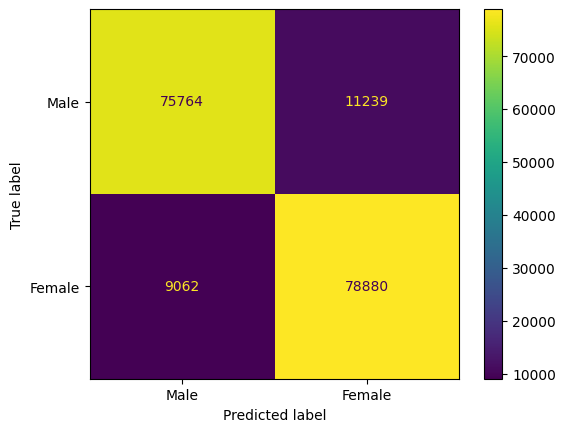

In [12]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['Male', 'Female'])
cm_display.plot()
plt.show()

In [13]:
#torch.save(model.state_dict(), 'vgg_model.pth')

## Inference

In [18]:
loaded_model = models.vgg16(pretrained=False)  # Load a new instance of VGG16
num_features = loaded_model.classifier[6].in_features
loaded_model.classifier[6] = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 2)
)
loaded_model.load_state_dict(torch.load('vgg_model.pth'))
loaded_model = loaded_model.to(device)
loaded_model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [20]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image.to(device)  # Move the image to GPU if available

image_paths = ['harun.jpg', 'arda.jpg']  # Provide paths to the images
for image_path in image_paths:
    input_image = preprocess_image(image_path)
    with torch.no_grad():
        output = loaded_model(input_image)
        probabilities = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        predicted_label = class_names[predicted_class]
        print(f"Image: {image_path}, Predicted Gender: {predicted_label}")

Image: harun.jpg, Predicted Gender: male
Image: arda.jpg, Predicted Gender: male
